In [1]:
import cv2
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
input_shape = (224, 224, 3) 
batch_size = 32
num_classes = 3
target_samples_per_class = 3000 // num_classes 
data_dir = "Spine/"
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# Load dataset
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
augmented_images = np.zeros((num_classes * target_samples_per_class, *input_shape))
augmented_labels = np.zeros((num_classes * target_samples_per_class, num_classes))
# Calculate the number of batches needed to reach the target number of samples per class
total_batches_per_class = target_samples_per_class // batch_size
extra_samples_per_class = target_samples_per_class % batch_size
extra_batches_per_class = 1 if extra_samples_per_class > 0 else 0
sample_index = 0
for class_folder in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_folder)
    num_samples = len(os.listdir(class_dir))
    num_batches_needed = total_batches_per_class + extra_batches_per_class if num_samples < target_samples_per_class else 0
    if num_batches_needed > 0:

        for i in range(num_batches_needed):
            batch = next(train_generator)
            images = batch[0]
            labels = batch[1]
            for j in range(images.shape[0]):
                if sample_index==3000:
                    break
                augmented_images[sample_index] = images[j]
                augmented_labels[sample_index] = labels[j]
                sample_index += 1         
           
print("Augmentation complete.")

Found 174 images belonging to 3 classes.
Augmentation complete.


In [33]:
np.save('Augmented_images.npy', augmented_images)
np.save('Augmented_labels.npy', augmented_labels)

In [3]:
X= augmented_images
y =augmented_labels

In [31]:
len(augmented_images)
d={0:0,1:0,2:0}
for i in augmented_labels:
    i=np.argmax(i)
    d[i]+=1 
print(d)



{0: 1176, 1: 960, 2: 864}


In [2]:

X=np.load('aug_images.npy')
y=np.load('aug_labels.npy')

In [4]:
y
y= y.argmax(axis=1)
y

array([2, 2, 1, ..., 0, 0, 0], dtype=int64)

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x) 
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

opt = Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)
# # Initialize LabelEncoder
# label_encoder = LabelEncoder()

# # Fit label encoder and transform labels to integers
# y_train_val = label_encoder.fit_transform(y_train_val)
# # y_val = label_encoder.transform(y_val)
# y_test = label_encoder.transform(y_test)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=True, stratify=y_train_val, random_state=123)

history = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), batch_size=32, shuffle=True)

Epoch 1/15
60/60 [==============================] - 214s 3s/step - loss: 1.0746 - accuracy: 0.4250 - val_loss: 0.8959 - val_accuracy: 0.5458
Epoch 2/15
60/60 [==============================] - 209s 3s/step - loss: 0.9244 - accuracy: 0.5375 - val_loss: 0.8153 - val_accuracy: 0.6167
Epoch 3/15
60/60 [==============================] - 202s 3s/step - loss: 0.8226 - accuracy: 0.6010 - val_loss: 0.7188 - val_accuracy: 0.6646
Epoch 4/15
60/60 [==============================] - 210s 4s/step - loss: 0.7885 - accuracy: 0.6203 - val_loss: 0.7273 - val_accuracy: 0.6687
Epoch 5/15
60/60 [==============================] - 203s 3s/step - loss: 0.6958 - accuracy: 0.6792 - val_loss: 0.6520 - val_accuracy: 0.7104
Epoch 6/15
60/60 [==============================] - 202s 3s/step - loss: 0.6576 - accuracy: 0.6969 - val_loss: 0.6635 - val_accuracy: 0.7042
Epoch 7/15
60/60 [==============================] - 202s 3s/step - loss: 0.6344 - accuracy: 0.7344 - val_loss: 0.6127 - val_accuracy: 0.7646
Epoch 8/15
60

In [6]:

history1= model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=32, shuffle=True)

Epoch 1/5
60/60 [==============================] - 199s 3s/step - loss: 0.3224 - accuracy: 0.8667 - val_loss: 0.5234 - val_accuracy: 0.7896
Epoch 2/5
60/60 [==============================] - 205s 3s/step - loss: 0.3252 - accuracy: 0.8745 - val_loss: 0.4849 - val_accuracy: 0.7917
Epoch 3/5
60/60 [==============================] - 208s 3s/step - loss: 0.2608 - accuracy: 0.9031 - val_loss: 0.4521 - val_accuracy: 0.8208
Epoch 4/5
60/60 [==============================] - 221s 4s/step - loss: 0.2736 - accuracy: 0.8948 - val_loss: 0.4748 - val_accuracy: 0.8021
Epoch 5/5
60/60 [==============================] - 209s 3s/step - loss: 0.2353 - accuracy: 0.9062 - val_loss: 0.4687 - val_accuracy: 0.8062


In [7]:

history2= model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=32, shuffle=True)

Epoch 1/5
60/60 [==============================] - 206s 3s/step - loss: 0.2146 - accuracy: 0.9193 - val_loss: 0.4366 - val_accuracy: 0.8250
Epoch 2/5
60/60 [==============================] - 203s 3s/step - loss: 0.1841 - accuracy: 0.9328 - val_loss: 0.4707 - val_accuracy: 0.8146
Epoch 3/5
60/60 [==============================] - 221s 4s/step - loss: 0.2042 - accuracy: 0.9187 - val_loss: 0.4172 - val_accuracy: 0.8417
Epoch 4/5
60/60 [==============================] - 203s 3s/step - loss: 0.2083 - accuracy: 0.9187 - val_loss: 0.4136 - val_accuracy: 0.8271
Epoch 5/5
60/60 [==============================] - 200s 3s/step - loss: 0.1580 - accuracy: 0.9391 - val_loss: 0.4447 - val_accuracy: 0.8271


In [8]:

history3= model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=32, shuffle=True)

Epoch 1/5
60/60 [==============================] - 209s 3s/step - loss: 0.1488 - accuracy: 0.9417 - val_loss: 0.4423 - val_accuracy: 0.8354
Epoch 2/5
60/60 [==============================] - 204s 3s/step - loss: 0.1391 - accuracy: 0.9505 - val_loss: 0.4785 - val_accuracy: 0.8375
Epoch 3/5
60/60 [==============================] - 209s 3s/step - loss: 0.1226 - accuracy: 0.9557 - val_loss: 0.4358 - val_accuracy: 0.8542
Epoch 4/5
60/60 [==============================] - 205s 3s/step - loss: 0.1250 - accuracy: 0.9557 - val_loss: 0.5612 - val_accuracy: 0.8125
Epoch 5/5
60/60 [==============================] - 206s 3s/step - loss: 0.1085 - accuracy: 0.9620 - val_loss: 0.4429 - val_accuracy: 0.8500


In [9]:

history4= model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=32, shuffle=True)

Epoch 1/5
60/60 [==============================] - 210s 3s/step - loss: 0.0882 - accuracy: 0.9667 - val_loss: 0.4331 - val_accuracy: 0.8479
Epoch 2/5
60/60 [==============================] - 212s 4s/step - loss: 0.0859 - accuracy: 0.9693 - val_loss: 0.4318 - val_accuracy: 0.8604
Epoch 3/5
60/60 [==============================] - 207s 3s/step - loss: 0.1038 - accuracy: 0.9589 - val_loss: 0.4969 - val_accuracy: 0.8354
Epoch 4/5
60/60 [==============================] - 207s 3s/step - loss: 0.1223 - accuracy: 0.9521 - val_loss: 0.4640 - val_accuracy: 0.8458
Epoch 5/5
60/60 [==============================] - 203s 3s/step - loss: 0.0948 - accuracy: 0.9677 - val_loss: 0.4996 - val_accuracy: 0.8250


In [10]:

history5= model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=32, shuffle=True)

Epoch 1/5
60/60 [==============================] - 204s 3s/step - loss: 0.0628 - accuracy: 0.9812 - val_loss: 0.4433 - val_accuracy: 0.8583
Epoch 2/5
60/60 [==============================] - 206s 3s/step - loss: 0.0651 - accuracy: 0.9755 - val_loss: 0.5380 - val_accuracy: 0.8417
Epoch 3/5
60/60 [==============================] - 203s 3s/step - loss: 0.0732 - accuracy: 0.9724 - val_loss: 0.4873 - val_accuracy: 0.8417
Epoch 4/5
60/60 [==============================] - 209s 3s/step - loss: 0.0931 - accuracy: 0.9677 - val_loss: 0.4754 - val_accuracy: 0.8500
Epoch 5/5
60/60 [==============================] - 214s 4s/step - loss: 0.0631 - accuracy: 0.9781 - val_loss: 0.4623 - val_accuracy: 0.8625


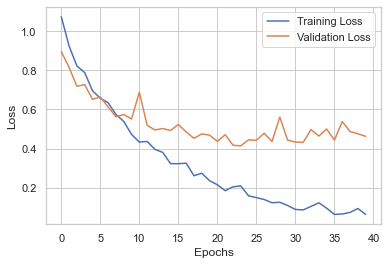

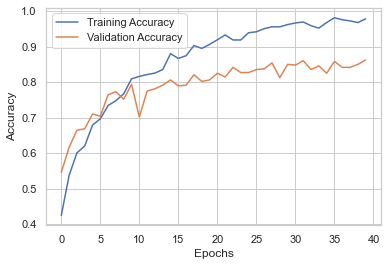

In [19]:
import matplotlib.pyplot as plt

def combine_histories(*histories):
    combined_history = {}
    for history in histories:
        for key, value in history.history.items():
            if key not in combined_history:
                combined_history[key] = []
            combined_history[key].extend(value)
    return combined_history

# Example usage
combined_history = combine_histories(history, history1, history2,history3,history4,history5)  # Replace history, history1, history2, ... with your actual history variables

# Plot combined history
plt.plot(combined_history['loss'], label='Training Loss')
plt.plot(combined_history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(combined_history['accuracy'], label='Training Accuracy')
plt.plot(combined_history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [21]:
test_loss, test_acc = model.evaluate(X_test,y_test)
print('Test Accuracy:', test_acc)

19/19 [==============================] - 49s 3s/step - loss: 0.4254 - accuracy: 0.8817
Test Accuracy: 0.8816666603088379


In [24]:
y_pred=model.predict(X_test)

19/19 [==============================] - 50s 2s/step


In [25]:
y_pred

array([[9.9987042e-01, 1.2946084e-04, 1.3168095e-07],
       [2.7495690e-04, 3.3232702e-03, 9.9640179e-01],
       [1.0000000e+00, 2.2938887e-10, 2.4369536e-08],
       ...,
       [2.7072369e-07, 9.9999857e-01, 1.1328441e-06],
       [4.8075087e-04, 1.4665870e-03, 9.9805272e-01],
       [1.0129673e-05, 3.2714385e-01, 6.7284602e-01]], dtype=float32)

In [28]:
y_pred_v= y_pred.argmax(axis=1)

In [29]:
import numpy as np
from sklearn.metrics import accuracy_score


# Calculate accuracy for each class
class_accuracies = []
for class_label in range(3):
    indices = np.where(y_test== class_label)[0]
    class_predictions = y_pred_v[indices]
    class_true_labels = y_test[indices]
    class_accuracy = accuracy_score(class_true_labels, class_predictions)
    class_accuracies.append(class_accuracy)

# Print class-wise accuracies
classes = ['normal', 'osteophenia', 'osteporosis']
for i, class_accuracy in enumerate(class_accuracies):
    print(f'{classes[i]} Accuracy: {class_accuracy:.4f}')


normal Accuracy: 0.9149
osteophenia Accuracy: 0.8490
osteporosis Accuracy: 0.8728


In [30]:
model.save('M_SPINE_DNET_with_aug.h5')

D:\anaconda\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('M_SPINE_DNET_with_aug.h5')  # Replace 'my_model.h5' with the path to your saved model file


NameError: name 'X_train' is not defined

In [3]:
import numpy as np
# Load augmented_images array
augmented_images = np.load('Augmented_images.npy')

# Load augmented_labels array
augmented_labels = np.load('Augmented_labels.npy')


In [5]:
import cv2
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers

In [6]:
X= augmented_images
y =augmented_labels
y= y.argmax(axis=1)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)


X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=True, stratify=y_train_val, random_state=123)

history6 = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32, shuffle=True)

Epoch 1/10
60/60 [==============================] - 216s 3s/step - loss: 0.0553 - accuracy: 0.9807 - val_loss: 0.5166 - val_accuracy: 0.8604
Epoch 2/10
60/60 [==============================] - 206s 3s/step - loss: 0.0591 - accuracy: 0.9781 - val_loss: 0.5221 - val_accuracy: 0.8542
Epoch 3/10
60/60 [==============================] - 203s 3s/step - loss: 0.0496 - accuracy: 0.9875 - val_loss: 0.5154 - val_accuracy: 0.8583
Epoch 4/10
60/60 [==============================] - 201s 3s/step - loss: 0.0603 - accuracy: 0.9776 - val_loss: 0.7958 - val_accuracy: 0.7979
Epoch 5/10
60/60 [==============================] - 200s 3s/step - loss: 0.0750 - accuracy: 0.9698 - val_loss: 0.4774 - val_accuracy: 0.8625
Epoch 6/10
60/60 [==============================] - 233s 4s/step - loss: 0.0899 - accuracy: 0.9672 - val_loss: 0.7347 - val_accuracy: 0.8000
Epoch 7/10
60/60 [==============================] - 236s 4s/step - loss: 0.0627 - accuracy: 0.9812 - val_loss: 0.4256 - val_accuracy: 0.8646
Epoch 8/10
60